In [1]:
import itertools
import sys

import cirq
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("..")

from sim.circuit import gen_1d_chain_xeb_random_circuit
from sim.simulate import large_scale_xeb_sim
from sim.parallel import run

In [7]:
exponents = np.linspace(0, 7/4, 8)
SINGLE_QUBIT_GATES = tuple(
    cirq.PhasedXZGate(x_exponent=0.5, z_exponent=z, axis_phase_exponent=a)
    for a, z in itertools.product(exponents, repeat=2)
)

MAX_DEPTH = 200
N = 10
n_circuits = 100
e_paulis = np.linspace(0.5e-3, 1e-2, 8)

In [8]:
qubits = cirq.LineQubit.range(N)
circuits = [gen_1d_chain_xeb_random_circuit
    (
        qubits,
        depth=MAX_DEPTH,
        single_qubit_gates=SINGLE_QUBIT_GATES,
        two_qubit_op_factory=lambda a, b, _: cirq.SQRT_ISWAP(a, b)
    )
    for _ in range(n_circuits)
]

In [5]:
cycle_depths = np.arange(1, 51)
def run(e_pauli):
    noise_model = cirq.devices.noise_model.ConstantQubitNoiseModel(cirq.depolarize(e_pauli))
    
    xebs = np.mean([
        large_scale_xeb_sim(circuit, noise_model, cycle_depths=cycle_depths)
        for circuit in circuits
    ], axis=0)
    return e_pauli, xebs

In [9]:
# import multiprocessing

# pool = multiprocessing.Pool(7)

res = []
# def log_result(result):
#     res.append(result)

# e_paulis = np.linspace(0.5e-3, 1e-2, 8)
# for e_pauli in e_paulis:
#     pool.apply_async(run, (e_pauli,), callback=log_result)
# pool.close()
# pool.join()
for e_pauli in e_paulis:
    noise_model = cirq.devices.noise_model.ConstantQubitNoiseModel(cirq.depolarize(e_pauli))
    
    xebs = np.mean([
        large_scale_xeb_sim(circuit, noise_model, cycle_depths=cycle_depths)
        for circuit in circuits
    ], axis=0)
    res[e_pauli] = xebs

10 qubits pure state simulation:   0%|          | 0/101 [00:00<?, ?it/s]

10 qubits noisy state simulation:  40%|███▉      | 40/101 [00:19<00:29,  2.04it/s]


KeyboardInterrupt: 

In [5]:
xeb_ratios = {}
for e_pauli, xebs in res:
    ratio = xebs[1:] / xebs[:-1]
    xeb_ratios[e_pauli] = np.log(ratio)

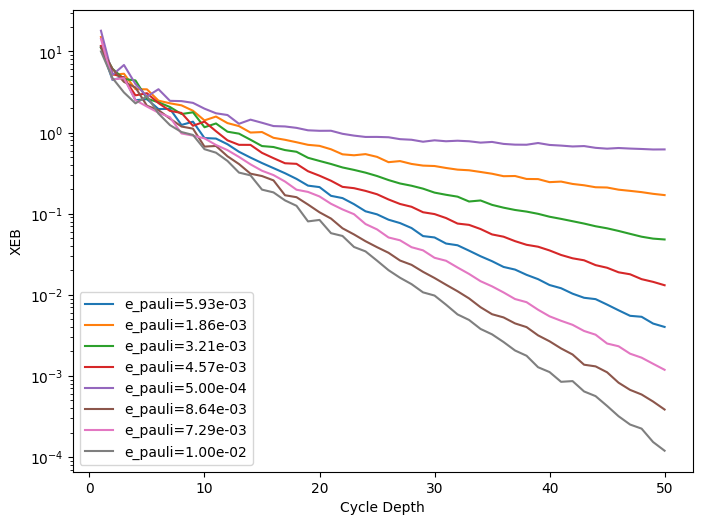

In [7]:
cycle_depths = np.arange(1, 51)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_yscale("log")
for e_pauli, xebs in res:
    ax.plot(cycle_depths, xebs, label=f"e_pauli={e_pauli:.2e}")
ax.set_xlabel("Cycle Depth")
ax.set_ylabel("XEB")
ax.legend()

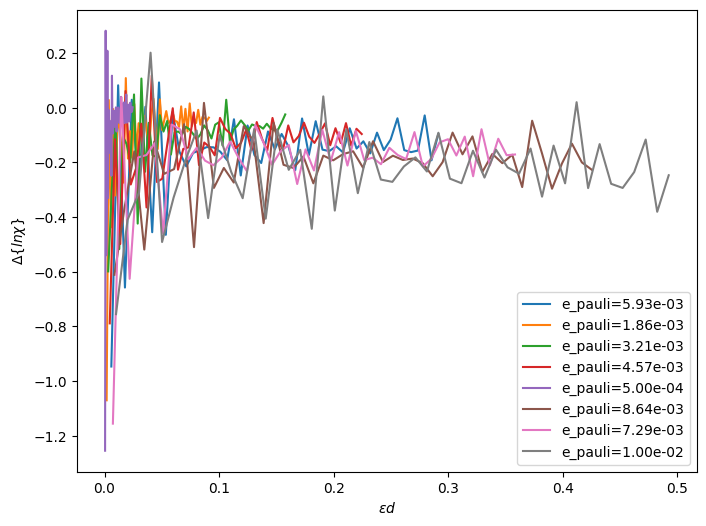

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
for e_pauli, ratios in xeb_ratios.items():
    ax.plot(-np.log(1 - e_pauli) * cycle_depths[:-1], ratios, label=f"e_pauli={e_pauli:.2e}")
ax.set_xlabel("$\epsilon d$")
ax.set_ylabel(r"$\Delta \{ ln\chi \}$")
ax.legend()